Make the H5O2 xyz

In [1]:
from nbed.utils import (
    pubchem_mol_geometry,
    build_ordered_xyz_string,
    save_ordered_xyz_file,
)
import numpy as np

water = pubchem_mol_geometry("water")

/Users/michaelwilliamsdelabastida/Library/Caches/pypoetry/virtualenvs/nbed-1_9TTDE1-py3.10/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
water

{0: ('O', (0, 0, 0)),
 1: ('H', (0.2774, 0.8929, 0.2544)),
 2: ('H', (0.6068, -0.2383, -0.7169))}

In [3]:
h1 = np.array(water[1][1])
h2 = np.array(water[2][1])

In [14]:
av_h_dist = (np.linalg.norm(h1) + np.linalg.norm(h2))/2
av_h_dist

0.9689889756853722

In [5]:
# angle between the two H atoms
h_angle = np.arccos(np.dot(water[1][1], water[2][1])/(np.sqrt(np.sum([w**2 for w in water[1][1]]))*np.sqrt(np.sum([w**2 for w in water[2][1]]))))

In [6]:
hy = av_h_dist*np.sin(h_angle/2)
hx = av_h_dist*np.cos(h_angle/2)

In [7]:
hx, hy

(0.5967028259526409, 0.7634693002995727)

In [8]:
new_water = {0: ('O', (0, 0, 0)), 1: ('H', (-hx, hy, 0)), 2: ('H', (-hx, -hy, 0))} 
new_water

{0: ('O', (0, 0, 0)),
 1: ('H', (-0.5967028259526409, 0.7634693002995727, 0)),
 2: ('H', (-0.5967028259526409, -0.7634693002995727, 0))}

In [9]:
# make a function for setting up 2 water molecules

def two_water_geometry(ox_dist: float, delta: float):
    """
    Args:
    ox_dist: distance between the two oxygen atoms
    delta: proportion of distance between the two oxygen atoms to place the third H atom
    """

    if not (0 < delta < 1):
        raise ValueError("delta must be between 0 and 1")

    full_system = {}
    full_system[0] = new_water[0]
    full_system[1] = new_water[1]
    full_system[2] = new_water[2]

    full_system[3] = ('O', (ox_dist, 0, 0))
    full_system[4] = ('H', (ox_dist - new_water[1][1][0], new_water[1][1][1], 0))
    full_system[5] = ('H', (ox_dist - new_water[2][1][0], new_water[2][1][1], 0))

    full_system[6] = ('H', (ox_dist*delta, 0, 0))

    string_form = "; ".join([f"""{f[0]} {f[1][0]} {f[1][1]} {f[1][2]}""" for f in full_system.values()])

    return string_form
                    

In [75]:
from pathlib import Path
from pyscf import gto, scf, cc

energies = {}

oo_distances = np.linspace(2, 5, 20)
deltas = np.linspace(0.1, 0.5, 20)

for o_dist in oo_distances:
    energies[o_dist] = []
    for delta in deltas:
        pass_geo = two_water_geometry(o_dist, delta)
        mol = gto.Mole(atom=pass_geo, basis='sto-3g', charge=1)
        mol.build()

        hf = scf.RHF(mol).run()
        ccsd = cc.CCSD(hf).run()
        energies[o_dist].append(ccsd.e_tot)

print("NAO: ", mol.nao)

converged SCF energy = -141.028622607999
E(CCSD) = -141.1077423298422  E_corr = -0.07911972184348444
converged SCF energy = -143.750196805255
E(CCSD) = -143.8318281270012  E_corr = -0.08163132174598584
converged SCF energy = -145.582404472395
E(CCSD) = -145.6667829627361  E_corr = -0.08437849034123167
converged SCF energy = -146.866631708088
E(CCSD) = -146.9536665266813  E_corr = -0.08703481859372587
converged SCF energy = -147.788306531752
E(CCSD) = -147.8777400060591  E_corr = -0.08943347430668543
converged SCF energy = -148.460016123262
E(CCSD) = -148.5515728829348  E_corr = -0.09155675967310176
converged SCF energy = -148.954775547105
E(CCSD) = -149.048230032028  E_corr = -0.09345448492298866
converged SCF energy = -149.32179876251
E(CCSD) = -149.4169864075328  E_corr = -0.095187645022465
converged SCF energy = -149.595215875336
E(CCSD) = -149.6920226543308  E_corr = -0.09680677899464354
converged SCF energy = -149.799276138071
E(CCSD) = -149.8976231244469  E_corr = -0.098346986376

# Plot the Energy surface as a function of O-O distance and $\delta_{O,H}$

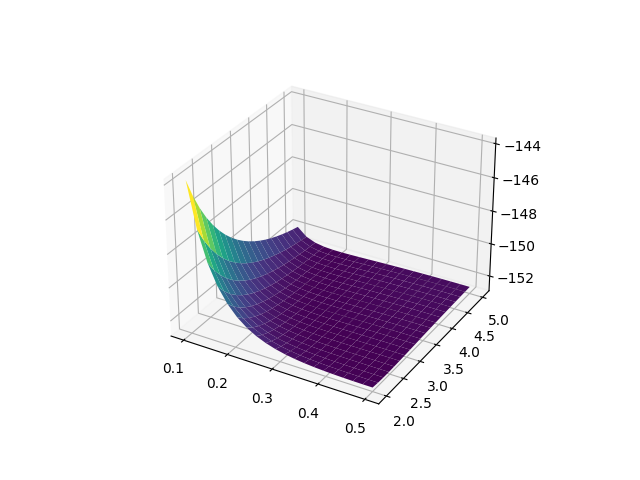

In [11]:
%matplotlib ipympl

x = deltas
y = oo_distances

X, Y = np.meshgrid(x, y)
Z = np.array([e for e in energies.values()])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3d plot the surface
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

# Similar plot, but with normalized values to see the double well.

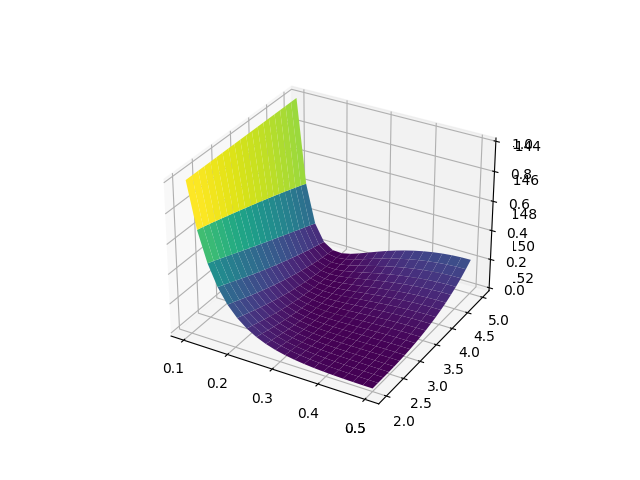

In [12]:
%matplotlib ipympl

x = deltas
y = oo_distances

X, Y = np.meshgrid(x, y)
Z = np.array([(e-np.min(e))/(np.max(e)-np.min(e)) for e in energies.values()])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3d plot the surface

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

# Where does the behaviour change from a double well to a single well?

In [13]:
for d, e in energies.items():
    if np.all(np.array(e)[1:]-np.array(e)[:-1] < 0):
        print(f"Single well at distance: {d}")

Single well at distance: 2.0
Single well at distance: 2.1578947368421053
Single well at distance: 2.3157894736842106


In [15]:
h_angle

1.8147923504529797

In [21]:
Oy = 3*np.sin(h_angle/2)
Ox = 3*np.cos(h_angle/2)
o1_os = Oy, Ox

In [22]:
h1_pos = np.sqrt(3**2 + av_h_dist**2)*np.sin(h_angle/2), np.sqrt(3**2 + av_h_dist**2)*np.cos(h_angle/2)

In [24]:
# distance from h1 to o1
h1_o1 = np.sqrt((h1_pos[0] - o1_os[0])**2 + (h1_pos[1] - o1_os[1])**2)
h1_o1

0.1526083859242315

In [68]:
def hydronium_geometry(ox_dist: float, delta: float):
    """
    Args:
    ox_dist: distance between the two oxygen atoms
    delta: proportion of distance between the two oxygen atoms to place the third H atom
    """

    if not (0 < delta < 1):
        raise ValueError("delta must be between 0 and 1")

    full_system = {}
    full_system[0] = new_water[0]
    full_system[1] = new_water[1]
    full_system[2] = new_water[2]

    full_system[3] = ('O', (ox_dist, 0, 0))
    full_system[4] = ('H', (ox_dist - new_water[1][1][0], new_water[1][1][1], 0))
    full_system[5] = ('H', (ox_dist - new_water[2][1][0], new_water[2][1][1], 0))

    full_system[6] = ('H', (ox_dist*delta, 0, 0))

    o1x = -2.363708936191661
    o1y = 1.8473981879843033
    h_dist = 0.9689889756853722

    full_system[7] = ('O', (o1x, o1y, 0))
    full_system[8] = ('H', (o1x - h_dist, o1y, 0))
    full_system[9] = ('H', (o1x + h_dist*np.cos(np.pi-h_angle), o1y + h_dist*np.sin(np.pi - h_angle), 0))

    full_system[10] = ('O', (o1x, -o1y, 0))
    full_system[11] = ('H', (o1x - h_dist, -o1y, 0))
    full_system[12] = ('H', (o1x + h_dist*np.cos(np.pi-h_angle), -o1y - h_dist*np.sin(np.pi - h_angle), 0))

    string_form = "\n".join([f"""{f[0]}\t{f[1][0]}\t{f[1][1]}\t{f[1][2]}""" for f in full_system.values()])

    return full_system, string_form

In [70]:
from nbed.utils import (
    pubchem_mol_geometry,
    build_ordered_xyz_string,
    save_ordered_xyz_file,
)

hgeo, hgeostring = build_ordered_xyz_string(hydronium_geometry(3, 0.5), [0,3,6])
print(hgeo)

{0: ('O', (0, 0, 0)), 1: ('H', (-0.5967028259526409, 0.7634693002995727, 0)), 2: ('H', (-0.5967028259526409, -0.7634693002995727, 0)), 3: ('O', (3, 0, 0)), 4: ('H', (3.596702825952641, 0.7634693002995727, 0)), 5: ('H', (3.596702825952641, -0.7634693002995727, 0)), 6: ('H', (1.5, 0, 0)), 7: ('O', (-2.363708936191661, 1.8473981879843033, 0)), 8: ('H', (-3.332697911877033, 1.8473981879843033, 0)), 9: ('H', (-2.129618440126303, 2.787686055954353, 0)), 10: ('O', (-2.363708936191661, -1.8473981879843033, 0)), 11: ('H', (-3.332697911877033, -1.8473981879843033, 0)), 12: ('H', (-2.129618440126303, -2.787686055954353, 0))}


AttributeError: 'tuple' object has no attribute 'keys'

In [72]:
from pathlib import Path
from pyscf import gto, scf, cc

hydronium_energies = {}

oo_distances = np.linspace(2, 5, 20)
deltas = np.linspace(0.1, 0.5, 20)

for o_dist in oo_distances:
    hydronium_energies[o_dist] = []
    for delta in deltas:
        _, pass_geo = hydronium_geometry(o_dist, delta)
        mol = gto.Mole(atom=pass_geo, basis='sto-3g', charge=1)
        mol.build()

        hf = scf.RHF(mol).run()
        ccsd = cc.CCSD(hf).run()
        hydronium_energies[o_dist].append(ccsd.e_tot)

print("NAO: ", mol.nao)

{0: ('O', (0, 0, 0)), 1: ('H', (-0.5967028259526409, 0.7634693002995727, 0)), 2: ('H', (-0.5967028259526409, -0.7634693002995727, 0)), 3: ('O', (2.0, 0, 0)), 4: ('H', (2.596702825952641, 0.7634693002995727, 0)), 5: ('H', (2.596702825952641, -0.7634693002995727, 0)), 6: ('H', (0.2, 0, 0)), 7: ('O', (-2.363708936191661, 1.8473981879843033, 0)), 8: ('H', (-3.332697911877033, 1.8473981879843033, 0)), 9: ('H', (-2.129618440126303, 2.787686055954353, 0)), 10: ('O', (-2.363708936191661, -1.8473981879843033, 0)), 11: ('H', (-3.332697911877033, -1.8473981879843033, 0)), 12: ('H', (-2.129618440126303, -2.787686055954353, 0))}
converged SCF energy = -291.034814890773
E(CCSD) = -291.2136475595486  E_corr = -0.1788326687756815
{0: ('O', (0, 0, 0)), 1: ('H', (-0.5967028259526409, 0.7634693002995727, 0)), 2: ('H', (-0.5967028259526409, -0.7634693002995727, 0)), 3: ('O', (2.0, 0, 0)), 4: ('H', (2.596702825952641, 0.7634693002995727, 0)), 5: ('H', (2.596702825952641, -0.7634693002995727, 0)), 6: ('H', 

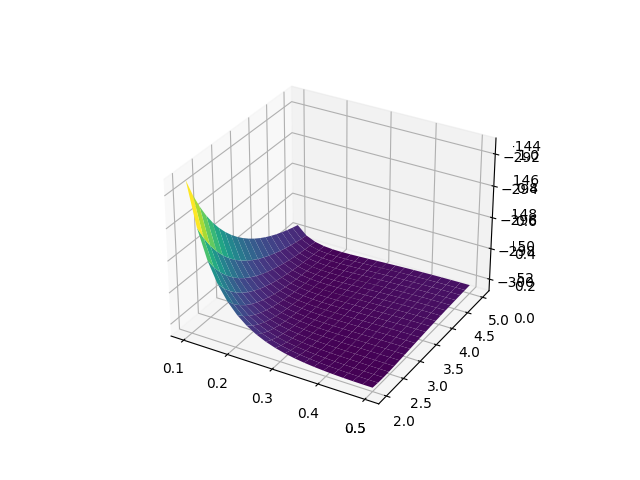

In [73]:
%matplotlib ipympl

x = deltas
y = oo_distances

X, Y = np.meshgrid(x, y)
Z = np.array([e for e in hydronium_energies.values()])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3d plot the surface
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

In [ ]:
%matplotlib ipympl

x = deltas
y = oo_distances

X, Y = np.meshgrid(x, y)
Z = np.array([(e-np.min(e))/(np.max(e)-np.min(e)) for e in hydronium_energies.values()])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 3d plot the surface

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.show()

In [66]:
from nbed.driver import NbedDriver

args = {
    "geometry": hgeo,
    "n_active_atoms": 3,
    "basis": "sto-3g",
    "xc_functional": "b3lyp",
    "projector": "both",
    "localization": "spade",
    "convergence": 1e-6,
    "max_ram_memory": 8_000,
    "charge":1,
    "spin":1,
}

driver = NbedDriver(**args)

RuntimeError: Electron number 40 and spin 1 are not consistent
Note mol.spin = 2S = Nalpha - Nbeta, not 2S+1